In [1]:
#coding=utf-8
%matplotlib inline

import os, sys, cv2, pickle
from multiprocessing import Pool
from functools import partial
from time import time
import matplotlib


# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
  
import matplotlib.pyplot as plt
from datetime import datetime
from utils import *
from scipy import misc, ndimage, signal, sparse, io
import imageio
from functools import reduce
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Flatten,Activation,Lambda
from keras.layers.convolutional import Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint  

import argparse

import tensorflow as tf

import torch
from torch import nn as nn
from torch_snippets import *


2022-05-26 11:40:29.681826: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-05-26 11:40:29.681851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
parser = argparse.ArgumentParser(description='Train-Test-Deploy')
parser.add_argument('GPU', type=str, default="4",
                    help='Your GPU ID')
parser.add_argument('mode', type=str, default="train",
                    help='train-test, test or deploy')
args = parser.parse_args()


os.environ["CUDA_VISIBLE_DEVICES"]=args.GPU
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

batch_size = 2
use_multiprocessing = False

train_set = ['../datasets/CISL24218/',]
train_sample_rate = None
test_set = ['../datasets/NISTSD27/',]
deploy_set = ['../datasets/NISTSD27/images/','../datasets/CISL24218/', \
       '../datasets/FVC2002DB2A/','../datasets/NIST4/','../datasets/NIST14/']
pretrain = '../models/released_version/Model.model'
output_dir = '../output/'+datetime.now().strftime('%Y%m%d-%H%M%S')
logging = init_log(output_dir)
copy_file(sys.path[0]+'/'+sys.argv[0], output_dir+'/')

usage: ipykernel_launcher.py [-h] GPU mode
ipykernel_launcher.py: error: the following arguments are required: mode


SystemExit: 2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
train_set = ['../datasets/CISL24218/',]
train_sample_rate = None
test_set = ['../datasets/NISTSD27/',]
deploy_set = ['../datasets/NISTSD27/images/','../datasets/CISL24218/', \
       '../datasets/FVC2002DB2A/','../datasets/NIST4/','../datasets/NIST14/']
pretrain = '../models/released_version/Model.model'

In [5]:
kernal2angle = np.reshape(np.arange(1, 180, 2, dtype=float), [1,1,1,90])/90.*np.pi #2angle = angle*2
sin2angle, cos2angle = np.sin(kernal2angle), np.cos(kernal2angle)
def ori2angle(ori):
    sin2angle_ori = K.sum(ori*sin2angle, -1, keepdims=True)
    cos2angle_ori = K.sum(ori*cos2angle, -1, keepdims=True)
    
    modulus_ori = K.sqrt(K.square(sin2angle_ori)+K.square(cos2angle_ori))
    # print('Aqui em ori2angle: ', modulus_ori)
    return sin2angle_ori, cos2angle_ori, modulus_ori

def ori_loss(y_true, y_pred, lamb=1.):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # get ROI
    label_seg = K.sum(y_true, axis=-1, keepdims=True)
    label_seg = tf.cast(tf.math.greater(label_seg, 0), tf.float32) 
    # weighted cross entropy loss
    lamb_pos, lamb_neg = 1., 1. 
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    logloss = logloss*label_seg # apply ROI
    logloss = -K.sum(logloss) / (K.sum(label_seg) + K.epsilon())
    # coherence loss, nearby ori should be as near as possible
    mean_kernal = np.reshape(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)/8, [3, 3, 1, 1])    
    sin2angle_ori, cos2angle_ori, modulus_ori = ori2angle(y_pred)
    sin2angle = K.conv2d(sin2angle_ori, mean_kernal, padding='same')
    cos2angle = K.conv2d(cos2angle_ori, mean_kernal, padding='same')
    modulus = K.conv2d(modulus_ori, mean_kernal, padding='same')
    coherence = K.sqrt(K.square(sin2angle) + K.square(cos2angle)) / (modulus + K.epsilon())
    coherenceloss = K.sum(label_seg) / (K.sum(coherence*label_seg) + K.epsilon()) - 1
    loss = logloss + lamb*coherenceloss
    return loss

def ori_o_loss(y_true, y_pred):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # get ROI
    label_seg = K.sum(y_true, axis=-1, keepdims=True)
    label_seg = tf.cast(tf.math.greater(label_seg, 0), tf.float32) 
    # weighted cross entropy loss
    lamb_pos, lamb_neg= 1., 1. 
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    logloss = logloss*label_seg # apply ROI
    logloss = -K.sum(logloss) / (K.sum(label_seg) + K.epsilon())
    return logloss

def seg_loss(y_true, y_pred, lamb=1.):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # weighted cross entropy loss
    total_elements = K.sum(tf.ones_like(y_true))
    label_pos = tf.cast(tf.math.greater(y_true, 0.0), tf.float32)   
    lamb_pos = 0.5 * total_elements / K.sum(label_pos)
    lamb_neg = 1 / (2 - 1/lamb_pos)
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    logloss = -K.mean(K.sum(logloss, axis=-1))
    # smooth loss
    smooth_kernal = np.reshape(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32)/8, [3, 3, 1, 1])
    smoothloss = K.mean(K.abs(K.conv2d(y_pred, smooth_kernal)))
    loss = logloss + lamb*smoothloss
    return loss

def mnt_s_loss(y_true, y_pred):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # get ROI
    label_seg = tf.cast(tf.not_equal(y_true, 0.0), tf.float32) 
    y_true = tf.where(tf.less(y_true,0.0), tf.zeros_like(y_true), y_true) # set -1 -> 0
    # weighted cross entropy loss       
    total_elements = K.sum(label_seg) + K.epsilon()  
    lamb_pos, lamb_neg = 10., .5
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    # apply ROI
    logloss = logloss*label_seg
    logloss = -K.sum(logloss) / total_elements
    return logloss    

# find highest peak using gaussian
def ori_highest_peak(y_pred, length=180):
    glabel = gausslabel(length=length,stride=2).astype(np.float32)
    ori_gau = K.conv2d(y_pred,glabel,padding='same')
    return ori_gau

def ori_acc_delta_k(y_true, y_pred, k=10, max_delta=180):
    # get ROI
    label_seg = K.sum(y_true, axis=-1)
    label_seg = tf.cast(tf.math.greater(label_seg, 0), tf.float32) 
    # get pred angle    
    angle = K.cast(K.argmax(ori_highest_peak(y_pred, max_delta), axis=-1), dtype=tf.float32)*2.0+1.0
    # get gt angle
    angle_t = K.cast(K.argmax(y_true, axis=-1), dtype=tf.float32)*2.0+1.0
    # get delta
    angle_delta = K.abs(angle_t - angle)
    acc = tf.less_equal(K.minimum(angle_delta, max_delta-angle_delta), k)
    acc = K.cast(acc, dtype=tf.float32)
    # apply ROI
    acc = acc*label_seg
    acc = K.sum(acc) / (K.sum(label_seg)+K.epsilon())
    return acc
def ori_acc_delta_10(y_true, y_pred):
    return ori_acc_delta_k(y_true, y_pred, 10)
def ori_acc_delta_20(y_true, y_pred):
    return ori_acc_delta_k(y_true, y_pred, 20)
def mnt_acc_delta_10(y_true, y_pred):
    return ori_acc_delta_k(y_true, y_pred, 10, 360)
def mnt_acc_delta_20(y_true, y_pred):
    return ori_acc_delta_k(y_true, y_pred, 20, 360)    

def seg_acc_pos(y_true, y_pred):
    y_true = tf.where(tf.less(y_true,0.0), tf.zeros_like(y_true), y_true)
    acc = K.cast(K.equal(y_true, K.round(y_pred)), dtype=tf.float32)
    acc = K.sum(acc * y_true) / (K.sum(y_true)+K.epsilon())
    return acc    
def seg_acc_neg(y_true, y_pred):
    y_true = tf.where(tf.less(y_true,0.0), tf.zeros_like(y_true), y_true)
    acc = K.cast(K.equal(y_true, K.round(y_pred)), dtype=tf.float32)
    acc = K.sum(acc * (1-y_true)) / (K.sum(1-y_true)+K.epsilon())
    return acc
def seg_acc_all(y_true, y_pred):
    y_true = tf.where(tf.less(y_true,0.0), tf.zeros_like(y_true), y_true)
    return K.mean(K.equal(y_true, K.round(y_pred)))  

def mnt_mean_delta(y_true, y_pred):
    # get ROI
    label_seg = K.sum(y_true, axis=-1)
    label_seg = tf.cast(tf.math.greater(label_seg, 0), tf.float32) 
    # get pred pos    
    pos = K.cast(K.argmax(y_pred, axis=-1), dtype=tf.float32)
    # get gt pos
    pos_t = K.cast(K.argmax(y_true, axis=-1), dtype=tf.float32)
    # get delta
    pos_delta = K.abs(pos_t - pos)
    # apply ROI
    pos_delta = pos_delta*label_seg
    mean_delta = K.sum(pos_delta) / (K.sum(label_seg)+K.epsilon())
    return mean_delta

    def train(input_shape=(512,512,1)):
        img_name, folder_name, img_size = get_maximum_img_size_and_names(train_set, train_sample_rate)
        main_net_model = get_main_net((int(img_size[0]),int(img_size[1]),1), pretrain)
        plot_model(main_net_model, to_file=output_dir+'/model.png',show_shapes=True)
        adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)    
        main_net_model.compile(optimizer=adam, 
            loss={'ori_out_1':ori_loss, 'ori_out_2':ori_o_loss, 'seg_out':seg_loss, 
                    'mnt_o_out':ori_o_loss, 'mnt_w_out':ori_o_loss, 'mnt_h_out':ori_o_loss, 'mnt_s_out':mnt_s_loss}, 
            loss_weights={'ori_out_1':.1, 'ori_out_2':.1, 'seg_out':10., 
                    'mnt_w_out':.5, 'mnt_h_out':.5, 'mnt_o_out':.5,'mnt_s_out':200.},
            metrics={'ori_out_1':[ori_acc_delta_10,],
                     'ori_out_2':[ori_acc_delta_10,],
                     'seg_out':[seg_acc_pos, seg_acc_neg, seg_acc_all],
                     'mnt_o_out':[mnt_acc_delta_10,],
                     'mnt_w_out':[mnt_mean_delta,],
                     'mnt_h_out':[mnt_mean_delta,],
                     'mnt_s_out':[seg_acc_pos, seg_acc_neg, seg_acc_all]})
        for epoch in range(100):
            for i, train in enumerate(load_data((img_name, folder_name, img_size), tra_ori_model, rand=True, aug=0.7, batch_size=batch_size)):
                loss = main_net_model.train_on_batch(train[0], 
                    {'ori_out_1':train[1], 'ori_out_2':train[2], 'seg_out':train[3],
                    'mnt_w_out':train[4], 'mnt_h_out':train[5], 'mnt_o_out':train[6], 'mnt_s_out':train[7]})  
                if i%(20/batch_size) == 0:
                    logging.info("epoch=%d, step=%d", epoch, i)
                    logging.info("%s", " ".join(["%s:%.4f\n"%(x) for x in zip(main_net_model.metrics_names, loss)]))
                if i%(10000/batch_size) == (10000/batch_size)-1:
                    # test every 10000 pics
                    outdir = "%s/%03d_%05d/"%(output_dir, epoch, i)
                    re_mkdir(outdir)
                    savedir = "%s%s"%(outdir, str(epoch)+'_'+str(i))
                    main_net_model.save_weights(savedir, True)
                    for folder in test_set:
                        test([folder,], savedir, outdir, test_num=10, draw=False)
        return

# currently can only produce one each time
def label2mnt(mnt_s_out, mnt_w_out, mnt_h_out, mnt_o_out, thresh=0.5):
    mnt_s_out = np.squeeze(mnt_s_out)
    mnt_w_out = np.squeeze(mnt_w_out)
    mnt_h_out = np.squeeze(mnt_h_out)
    mnt_o_out = np.squeeze(mnt_o_out)
    assert len(mnt_s_out.shape)==2 and len(mnt_w_out.shape)==3 and len(mnt_h_out.shape)==3 and len(mnt_o_out.shape)==3 
    # get cls results
    mnt_sparse = sparse.coo_matrix(mnt_s_out>thresh)
    mnt_list = np.array(list(zip(mnt_sparse.row, mnt_sparse.col)), dtype=np.int32)
    if mnt_list.shape[0] == 0:
        return np.zeros((0, 4))
    # get regression results
    mnt_w_out = np.argmax(mnt_w_out, axis=-1)
    mnt_h_out = np.argmax(mnt_h_out, axis=-1)
    mnt_o_out = np.argmax(mnt_o_out, axis=-1) # TODO: use ori_highest_peak(np version)
    # get final mnt
    mnt_final = np.zeros((len(mnt_list), 4))
    mnt_final[:, 0] = mnt_sparse.col*8 + mnt_w_out[mnt_list[:,0], mnt_list[:,1]]
    mnt_final[:, 1] = mnt_sparse.row*8 + mnt_h_out[mnt_list[:,0], mnt_list[:,1]]
    mnt_final[:, 2] = (mnt_o_out[mnt_list[:,0], mnt_list[:,1]]*2-89.)/180*np.pi
    mnt_final[mnt_final[:, 2]<0.0, 2] = mnt_final[mnt_final[:, 2]<0.0, 2]+2*np.pi
    mnt_final[:, 3] = mnt_s_out[mnt_list[:,0], mnt_list[:, 1]]
    return mnt_final

def test(test_set, model, outdir, test_num=10, draw=True):
    logging.info("Testing %s:"%(test_set))
    img_name, folder_name, img_size = get_maximum_img_size_and_names(test_set)  
    main_net_model = get_main_net((int(img_size[0]),int(img_size[1]),1), model)
    nonsense = SGD(lr=0.0, momentum=0.0, decay=0.0, nesterov=False)    
    main_net_model.compile(optimizer=nonsense,
        loss={'ori_out_1':ori_loss, 'ori_out_2':ori_o_loss, 'seg_out':seg_loss, 
                'mnt_o_out':ori_o_loss, 'mnt_w_out':ori_o_loss, 'mnt_h_out':ori_o_loss, 'mnt_s_out':mnt_s_loss}, 
        loss_weights={'ori_out_1':.1, 'ori_out_2':.1, 'seg_out':10., 
                'mnt_w_out':.5, 'mnt_h_out':.5, 'mnt_o_out':.5,'mnt_s_out':200.},        
        metrics={'ori_out_1':[ori_acc_delta_10,ori_acc_delta_20],
                 'ori_out_2':[ori_acc_delta_10,ori_acc_delta_20],
                 'seg_out':[seg_acc_pos, seg_acc_neg, seg_acc_all],
                 'mnt_o_out':[mnt_acc_delta_10,mnt_acc_delta_20],
                 'mnt_w_out':[mnt_mean_delta,],
                 'mnt_h_out':[mnt_mean_delta,],
                 'mnt_s_out':[seg_acc_pos, seg_acc_neg, seg_acc_all]})
    ave_loss, ave_prf_nms = [], []
    for j, test in enumerate(load_data((img_name, folder_name, img_size), tra_ori_model, rand=False, aug=0.0, batch_size=1)):      
        if j < test_num:
            logging.info("%d / %d: %s"%(j+1, len(img_name), img_name[j]))    
            ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out  = main_net_model.predict(test[0])
            metrics = main_net_model.train_on_batch(test[0], 
                {'ori_out_1':test[1], 'ori_out_2':test[2], 'seg_out':test[3],
                'mnt_w_out':test[4], 'mnt_h_out':test[5], 'mnt_o_out':test[6], 'mnt_s_out':test[7]})  
            ave_loss.append(metrics)
            logging.info("%s", " ".join(["%s:%.4f\n"%(x) for x in zip(main_net_model.metrics_names, metrics)]))
            mnt_gt = label2mnt(test[7], test[4], test[5], test[6])
            mnt_s_out = mnt_s_out * test[3]
            mnt = label2mnt(mnt_s_out, mnt_w_out, mnt_h_out, mnt_o_out, thresh=0.5)
            mnt_nms = nms(mnt)
            p, r, f, l, o = mnt_P_R_F(mnt_gt, mnt_nms)
            logging.info("After_nms:\nprecision: %f\nrecall: %f\nf1-measure: %f\nlocation_dis: %f\norientation_delta:%f\n----------------\n"%(
                p, r, f, l, o))
            ave_prf_nms.append([p, r, f, l, o])            
            if draw:                         
                angval = sess.run(ori_highest_peak(ori_out_1))                           
                angval = (np.argmax(angval, axis=-1)*2-90)/180.*np.pi
                draw_ori_on_img(test[0], angval, seg_out, "%s%s_ori.png"%(outdir, test[8][0]))
                draw_minutiae(test[0], mnt_nms[:,:3], "%s%s_mnt.png"%(outdir, test[8][0]))
                draw_minutiae(test[0], mnt_gt[:,:3], "%s%s_mnt_gt.png"%(outdir, test[8][0]))
        else:
            break
    logging.info("Average testing results:")
    ave_loss = np.mean(np.array(ave_loss), 0)
    ave_prf_nms = np.mean(np.array(ave_prf_nms), 0)
    logging.info("\n%s\n", " ".join(["%s:%.4f\n"%(x) for x in zip(main_net_model.metrics_names, ave_loss)]))
    logging.info("After_nms:\nprecision: %f\nrecall: %f\nf1-measure: %f\nlocation_dis: %f\norientation_delta:%f\n----------------\n"%(
                    ave_prf_nms[0],ave_prf_nms[1],ave_prf_nms[2],ave_prf_nms[3],ave_prf_nms[4]))     
    return

def deploy(deploy_set, set_name=None):
    if set_name is None:
        set_name = deploy_set.split('/')[-2]
    mkdir(output_dir+'/'+set_name+'/')
    print("Predicting %s:"%(set_name)) 
    _, img_name = get_files_in_folder(deploy_set, '.bmp')
    if len(img_name) == 0:
        deploy_set = deploy_set+'images/'
        _, img_name = get_files_in_folder(deploy_set, '.bmp')
    img_size = imageio.imread(deploy_set+img_name[0]+'.bmp').shape
    img_size = np.array(img_size, dtype=np.int32)/8*8      
    main_net_model = get_main_net((int(img_size[0]),int(img_size[1]),1), pretrain)
    _, img_name = get_files_in_folder(deploy_set, '.bmp')
    time_c = []
    for i in range(0,len(img_name)):
        print("%s %d / %d: %s"%(set_name, i+1, len(img_name), img_name[i]))
        time_start = time()    
        image = imageio.imread(deploy_set+img_name[i]+'.bmp') / 255.0
        image = image[:int(img_size[0]),:int(img_size[1])]      
        image = np.reshape(image,[1, image.shape[0], image.shape[1], 1])
        enhance_img, ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out = main_net_model.predict(image)
        time_afterconv = time()
        round_seg = np.round(np.squeeze(seg_out))
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        seg_out = cv2.morphologyEx(round_seg, cv2.MORPH_OPEN, kernel)
        mnt = label2mnt(np.squeeze(mnt_s_out)*np.round(np.squeeze(seg_out)), mnt_w_out, mnt_h_out, mnt_o_out, thresh=0.5)
        mnt_nms = nms(mnt)
#        ori = sess.run(ori_highest_peak(ori_out_1))                           
#        ori = (np.argmax(ori, axis=-1)*2-90)/180.*np.pi  
        time_afterpost = time()
        mnt_writer(mnt_nms, img_name[i], img_size, "%s/%s/%s.mnt"%(output_dir, set_name, img_name[i]))        
#        draw_ori_on_img(image, ori, np.ones_like(seg_out), "%s/%s/%s_ori.png"%(output_dir, set_name, img_name[i]))        
        draw_minutiae(image, mnt_nms[:,:3], "%s/%s/%s_mnt.png"%(output_dir, set_name, img_name[i]))
        imageio.imsave("%s/%s/%s_enh.png"%(output_dir, set_name, img_name[i]), np.squeeze(enhance_img)*ndimage.zoom(np.round(np.squeeze(seg_out)), [8,8], order=0))
        imageio.imsave("%s/%s/%s_seg.png"%(output_dir, set_name, img_name[i]), ndimage.zoom(np.round(np.squeeze(seg_out)), [8,8], order=0)) 
#        io.savemat("%s/%s/%s.mat"%(output_dir, set_name, img_name[i]), {'orientation':ori, 'orientation_distribution_map':ori_out_1})
        time_afterdraw = time()
        time_c.append([time_afterconv-time_start, time_afterpost-time_afterconv, time_afterdraw-time_afterpost])
        print("load+conv: %.3fs, seg-postpro+nms: %.3f, draw: %.3f"%(time_c[-1][0],time_c[-1][1],time_c[-1][2]))
    time_c = np.mean(np.array(time_c),axis=0)
    print("Average: load+conv: %.3fs, oir-select+seg-post+nms: %.3f, draw: %.3f"%(time_c[0],time_c[1],time_c[2]))
    return  




In [6]:
# image normalization
def img_normalization(img_input, m0=0.0, var0=1.0):
    m = K.mean(img_input, axis=[1,2,3], keepdims=True)
    var = K.var(img_input, axis=[1,2,3], keepdims=True)
    after = K.sqrt(var0*tf.math.square(img_input-m)/var)
    image_n = tf.where(tf.math.greater(img_input, m), m0+after, m0-after)
    return image_n

# atan2 function
def atan2(y_x):
    y, x = y_x[0], y_x[1]+K.epsilon()
    atan = tf.math.atan(y/x)
    angle = tf.where(tf.math.greater(x,0.0), atan, tf.compat.v1.zeros_like(x))
    angle = tf.where(tf.math.logical_and(tf.math.less(x,0.0),  tf.math.greater_equal(y,0.0)), atan+np.pi, angle)
    angle = tf.where(tf.math.logical_and(tf.math.less(x,0.0),  tf.math.less(y,0.0)), atan-np.pi, angle)
    return angle

# traditional orientation estimation
def orientation(image, stride=8, window=17):
    with tf.compat.v1.keras.backend.name_scope('orientation'):
        # assert image.get_shape().as_list()[3] == 1, 'Images must be grayscale'
        strides = [1, stride, stride, 1]
        E = np.ones([window, window, 1, 1])
        sobelx = np.reshape(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float), [3, 3, 1, 1])
        sobely = np.reshape(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float), [3, 3, 1, 1])
        gaussian = np.reshape(gaussian2d((5, 5), 1), [5, 5, 1, 1])
        with tf.compat.v1.keras.backend.name_scope('sobel_gradient'):
            Ix = tf.compat.v1.nn.conv2d(image, sobelx, strides=[1,1,1,1], padding='SAME', name='sobel_x')
            Iy = tf.compat.v1.nn.conv2d(image, sobely, strides=[1,1,1,1], padding='SAME', name='sobel_y')
        with tf.compat.v1.keras.backend.name_scope('eltwise_1'):
            Ix2 = tf.math.multiply(Ix, Ix, name='IxIx')
            Iy2 = tf.math.multiply(Iy, Iy, name='IyIy')
            Ixy = tf.math.multiply(Ix, Iy, name='IxIy')
        with tf.compat.v1.keras.backend.name_scope('range_sum'):
            Gxx = tf.compat.v1.nn.conv2d(Ix2, E, strides=strides, padding='SAME', name='Gxx_sum')
            Gyy = tf.compat.v1.nn.conv2d(Iy2, E, strides=strides, padding='SAME', name='Gyy_sum')
            Gxy = tf.compat.v1.nn.conv2d(Ixy, E, strides=strides, padding='SAME', name='Gxy_sum')
        with tf.compat.v1.keras.backend.name_scope('eltwise_2'):
            Gxx_Gyy = tf.math.subtract(Gxx, Gyy, name='Gxx_Gyy')
            theta = atan2([2*Gxy, Gxx_Gyy]) + np.pi
        # two-dimensional low-pass filter: Gaussian filter here
        with tf.compat.v1.keras.backend.name_scope('gaussian_filter'):
            phi_x = tf.compat.v1.nn.conv2d(tf.math.cos(theta), gaussian, strides=[1,1,1,1], padding='SAME', name='gaussian_x')
            phi_y = tf.compat.v1.nn.conv2d(tf.math.sin(theta), gaussian, strides=[1,1,1,1], padding='SAME', name='gaussian_y')
            theta = atan2([phi_y, phi_x])/2
    return theta

def get_tra_ori():
    img_input=Input(shape=(None, None, 1))
    theta = Lambda(orientation)(img_input)
    model = Model(inputs=[img_input,], outputs=[theta,])
    return model
tra_ori_model = get_tra_ori()

def get_maximum_img_size_and_names(dataset, sample_rate=None):
    if sample_rate is None:
        sample_rate = [1]*len(dataset)
    img_name, folder_name, img_size = [], [], []
    for folder, rate in zip(dataset, sample_rate):
        _, img_name_t = get_files_in_folder(folder+'images/', '.bmp')
        img_name.extend(img_name_t.tolist()*rate)
        folder_name.extend([folder]*img_name_t.shape[0]*rate)
        img_size.append(np.array(imageio.imread(folder+'images/'+img_name_t[0]+'.bmp').shape))
    img_name = np.asarray(img_name)
    folder_name = np.asarray(folder_name)
    img_size = np.max(np.asarray(img_size), axis=0)
    # let img_size % 8 == 0
    img_size = np.array(np.ceil(img_size/8)*8,dtype=np.int32)
    return img_name, folder_name, img_size

def sub_load_data(data, img_size, aug): 
    img_name, dataset = data
    img = imageio.imread(dataset+'images/'+img_name+'.bmp')
    seg = imageio.imread(dataset+'seg_labels/'+img_name+'.png')
    try:
        ali = imageio.imread(dataset+'ori_labels/'+img_name+'.bmp')
    except:
        ali = np.zeros_like(img)
    mnt = np.array(mnt_reader(dataset+'mnt_labels/'+img_name+'.mnt'), dtype=float)
    if any(img.shape != img_size):
        # random pad mean values to reach required shape
        if np.random.rand()<aug:
            tra = np.int32(np.random.rand(2)*(np.array(img_size)-np.array(img.shape)))
        else:
            tra = np.int32(0.5*(np.array(img_size)-np.array(img.shape)))
        img_t = np.ones(img_size)*np.mean(img)
        seg_t = np.zeros(img_size)
        ali_t = np.ones(img_size)*np.mean(ali)
        img_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = img
        seg_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = seg
        ali_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = ali
        img = img_t
        seg = seg_t
        ali = ali_t
        mnt = mnt+np.array([tra[1],tra[0],0]) 
    if np.random.rand()<aug:
        # random rotation [0 - 360] & translation img_size / 4
        rot = np.random.rand() * 360
        tra = (np.random.rand(2)-0.5) / 2 * img_size 
        img = ndimage.rotate(img, rot, reshape=False, mode='reflect')
        img = ndimage.shift(img, tra, mode='reflect')
        seg = ndimage.rotate(seg, rot, reshape=False, mode='constant')
        seg = ndimage.shift(seg, tra, mode='constant')
        ali = ndimage.rotate(ali, rot, reshape=False, mode='reflect')
        ali = ndimage.shift(ali, tra, mode='reflect') 
        mnt_r = point_rot(mnt[:, :2], rot/180*np.pi, img.shape, img.shape)  
        mnt = np.column_stack((mnt_r+tra[[1, 0]], mnt[:, 2]-rot/180*np.pi))
    # only keep mnt that stay in pic & not on border
    mnt = mnt[(8<=mnt[:,0])*(mnt[:,0]<int(img_size[1])-8)*(8<=mnt[:, 1])*(mnt[:,1]<int(img_size[0])-8), :]
    return img, seg, ali, mnt   

def load_data(dataset, tra_ori_model, rand=False, aug=0.0, batch_size=1, sample_rate=None):
    if type(dataset[0]) == str:
        img_name, folder_name, img_size = get_maximum_img_size_and_names(dataset, sample_rate)
    else:
        img_name, folder_name, img_size = dataset
    if rand:
        rand_idx = np.arange(len(img_name))
        np.random.shuffle(rand_idx)
        img_name = img_name[rand_idx]
        folder_name = folder_name[rand_idx]
    if batch_size > 1 and use_multiprocessing==True:
        p = Pool(batch_size)        
    p_sub_load_data = partial(sub_load_data, img_size=img_size, aug=aug)
    for i in range(0,len(img_name), batch_size):
        have_alignment = np.ones([batch_size, 1, 1, 1])
        image = np.zeros((batch_size, int(img_size[0]), int(img_size[1]), 1))
        segment = np.zeros((batch_size, int(img_size[0]), int(img_size[1]), 1))
        alignment = np.zeros((batch_size, int(img_size[0]), int(img_size[1]), 1))
        minutiae_w = np.zeros((batch_size, int(img_size[0]/8), int(img_size[1]/8), 1))-1
        minutiae_h = np.zeros((batch_size, int(img_size[0]/8), int(img_size[1]/8), 1))-1
        minutiae_o = np.zeros((batch_size, int(img_size[0]/8), int(img_size[1]/8), 1))-1
        batch_name = [img_name[(i+j)%len(img_name)] for j in range(batch_size)]
        batch_f_name = [folder_name[(i+j)%len(img_name)] for j in range(batch_size)]

        if batch_size > 1 and use_multiprocessing==True:    
            results = list(p.map(p_sub_load_data, zip(batch_name, batch_f_name)))
        else:
            results = list(map(p_sub_load_data, zip(batch_name, batch_f_name)))

        for j in range(batch_size):
            img, seg, ali, mnt = results[j]
            if np.sum(ali) == 0:
                have_alignment[j, 0, 0, 0] = 0
            image[j, :, :, 0] = img / 255.0
            segment[j, :, :, 0] = seg / 255.0
            alignment[j, :, :, 0] = ali / 255.0
            minutiae_w[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 0] % 8
            minutiae_h[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 1] % 8
            minutiae_o[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 2]
        # get seg
        label_seg = segment[:, ::8, ::8, :]
        label_seg[label_seg>0] = 1
        label_seg[label_seg<=0] = 0
        minutiae_seg = (minutiae_o!=-1).astype(float)
        # get ori & mnt
        orientation = tra_ori_model.predict(alignment)        
        orientation = orientation/np.pi*180+90
        orientation[orientation>=180.0] = 0.0 # orientation [0, 180)
        minutiae_o = minutiae_o/np.pi*180+90 # [90, 450)
        minutiae_o[minutiae_o>360] = minutiae_o[minutiae_o>360]-360 # to current coordinate system [0, 360)
        minutiae_ori_o = np.copy(minutiae_o) # copy one
        minutiae_ori_o[minutiae_ori_o>=180] = minutiae_ori_o[minutiae_ori_o>=180]-180 # for strong ori label [0,180)      
        # ori 2 gaussian
        gaussian_pdf = signal.gaussian(361, 3)
        y = np.reshape(np.arange(1, 180, 2), [1,1,1,-1])
        delta = np.array(np.abs(orientation - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori = gaussian_pdf[delta]
        # ori_o 2 gaussian
        delta = np.array(np.abs(minutiae_ori_o - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori_o = gaussian_pdf[delta] 
        # mnt_o 2 gaussian
        y = np.reshape(np.arange(1, 360, 2), [1,1,1,-1])
        delta = np.array(np.abs(minutiae_o - y), dtype=int)  
        delta = np.minimum(delta, 360-delta)+180
        label_mnt_o = gaussian_pdf[delta]         
        # w 2 gaussian
        gaussian_pdf = signal.gaussian(17, 2)
        y = np.reshape(np.arange(0, 8), [1,1,1,-1])
        delta = (minutiae_w-y+8).astype(int)
        label_mnt_w = gaussian_pdf[delta]
        # h 2 gaussian
        delta = (minutiae_h-y+8).astype(int)
        label_mnt_h = gaussian_pdf[delta]
        # mnt cls label -1:neg, 0:no care, 1:pos
        label_mnt_s = np.copy(minutiae_seg)
        label_mnt_s[label_mnt_s==0] = -1 # neg to -1
        label_mnt_s = (label_mnt_s+ndimage.maximum_filter(label_mnt_s, size=(1,3,3,1)))/2 # around 3*3 pos -> 0
        # apply segmentation
        label_ori = label_ori * label_seg * have_alignment
        label_ori_o = label_ori_o * minutiae_seg
        label_mnt_o = label_mnt_o * minutiae_seg
        label_mnt_w = label_mnt_w * minutiae_seg
        label_mnt_h = label_mnt_h * minutiae_seg
        return image, label_ori, label_ori_o, label_seg, label_mnt_w, label_mnt_h, label_mnt_o, label_mnt_s, batch_name
#         yield image, label_ori, label_ori_o, label_seg, label_mnt_w, label_mnt_h, label_mnt_o, label_mnt_s, batch_name
#     if batch_size > 1 and use_multiprocessing==True:
#         p.close()
#         p.join()
#     return

def merge_mul(x):
    return reduce(lambda x,y:x*y, x)
def merge_sum(x):
    return reduce(lambda x,y:x+y, x)
def reduce_sum(x):
    return K.sum(x,axis=-1,keepdims=True) 
def merge_concat(x):
    return tf.concat(x,3)
def select_max(x):
    x = x / (K.max(x, axis=-1, keepdims=True)+K.epsilon())
    x = tf.where(tf.math.greater(x, 0.999), x, tf.compat.v1.zeros_like(x)) # select the biggest one
    x = x / (K.sum(x, axis=-1, keepdims=True)+K.epsilon()) # prevent two or more ori is selected
    return x  
def conv_bn(bottom, w_size, name, strides=(1,1), dilation_rate=(1,1)):
    top = Conv2D(w_size[0], (w_size[1],w_size[2]),
        kernel_regularizer=l2(5e-5),
        padding='same', 
        strides=strides,
        dilation_rate=dilation_rate,
        name='conv-'+name)(bottom)
    top = BatchNormalization(name='bn-'+name)(top)
    return top
def conv_bn_prelu(bottom, w_size, name, strides=(1,1), dilation_rate=(1,1)):
    if dilation_rate == (1,1):
        conv_type = 'conv'
    else:
        conv_type = 'atrousconv'
    top = Conv2D(w_size[0], (w_size[1],w_size[2]),
        kernel_regularizer=l2(5e-5),
        padding='same', 
        strides=strides,
        dilation_rate=dilation_rate,
        name=conv_type+name)(bottom)
    # print("Shape após conv: ", top.shape)
    top = BatchNormalization(name='bn-'+name)(top)
    top=PReLU(alpha_initializer='zero', shared_axes=[1,2], name='prelu-'+name)(top)
    return top
def get_main_net(input_shape=(512,512,1), weights_path=None):
    img_input=Input(input_shape)
    bn_img=Lambda(img_normalization, name='img_norm')(img_input)

    # feature extraction VGG
    conv=conv_bn_prelu(bn_img, (64,3,3), '1_1') 
    conv=conv_bn_prelu(conv, (64,3,3), '1_2')
    conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv)

    conv=conv_bn_prelu(conv, (128,3,3), '2_1') 
    conv=conv_bn_prelu(conv, (128,3,3), '2_2') 
    conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv)

    conv=conv_bn_prelu(conv, (256,3,3), '3_1') 
    conv=conv_bn_prelu(conv, (256,3,3), '3_2') 
    conv=conv_bn_prelu(conv, (256,3,3), '3_3')   
    conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv)

    # multi-scale ASPP
    scale_1=conv_bn_prelu(conv, (256,3,3), '4_1', dilation_rate=(1,1))
    ori_1=conv_bn_prelu(scale_1, (128,1,1), 'ori_1_1')
    ori_1=Conv2D(90, (1,1), padding='same', name='ori_1_2')(ori_1)
    seg_1=conv_bn_prelu(scale_1, (128,1,1), 'seg_1_1')
    seg_1=Conv2D(1, (1,1), padding='same', name='seg_1_2')(seg_1)

    scale_2=conv_bn_prelu(conv, (256,3,3), '4_2', dilation_rate=(4,4))
    ori_2=conv_bn_prelu(scale_2, (128,1,1), 'ori_2_1')
    ori_2=Conv2D(90, (1,1), padding='same', name='ori_2_2')(ori_2)    
    seg_2=conv_bn_prelu(scale_2, (128,1,1), 'seg_2_1')
    seg_2=Conv2D(1, (1,1), padding='same', name='seg_2_2')(seg_2)

    scale_3=conv_bn_prelu(conv, (256,3,3), '4_3', dilation_rate=(8,8))
    ori_3=conv_bn_prelu(scale_3, (128,1,1), 'ori_3_1')
    ori_3=Conv2D(90, (1,1), padding='same', name='ori_3_2')(ori_3)  
    seg_3=conv_bn_prelu(scale_3, (128,1,1), 'seg_3_1')
    seg_3=Conv2D(1, (1,1), padding='same', name='seg_3_2')(seg_3)

    # sum fusion for ori
    ori_out=Lambda(merge_sum)([ori_1, ori_2, ori_3]) 
    ori_out_1=Activation('sigmoid', name='ori_out_1')(ori_out)
    ori_out_2=Activation('sigmoid', name='ori_out_2')(ori_out)

    # sum fusion for segmentation
    seg_out=Lambda(merge_sum)([seg_1, seg_2, seg_3])
    seg_out=Activation('sigmoid', name='seg_out')(seg_out)
    # ----------------------------------------------------------------------------
    # enhance part
    filters_cos, filters_sin = gabor_bank(stride=2, Lambda=8)
    filter_img_real = Conv2D(filters_cos.shape[3],(filters_cos.shape[0],filters_cos.shape[1]),
        weights=[filters_cos, np.zeros([filters_cos.shape[3]])], padding='same',
        name='enh_img_real_1')(img_input)
    filter_img_imag = Conv2D(filters_sin.shape[3],(filters_sin.shape[0],filters_sin.shape[1]),
        weights=[filters_sin, np.zeros([filters_sin.shape[3]])], padding='same',
        name='enh_img_imag_1')(img_input)
    ori_peak = Lambda(ori_highest_peak)(ori_out_1)
    ori_peak = Lambda(select_max)(ori_peak) # select max ori and set it to 1
    upsample_ori = UpSampling2D(size=(8,8))(ori_peak)
    seg_round = Activation('softsign')(seg_out)      
    upsample_seg = UpSampling2D(size=(8,8))(seg_round)
    mul_mask_real = Lambda(merge_mul)([filter_img_real, upsample_ori])
    enh_img_real = Lambda(reduce_sum, name='enh_img_real_2')(mul_mask_real)
    mul_mask_imag = Lambda(merge_mul)([filter_img_imag, upsample_ori])
    enh_img_imag = Lambda(reduce_sum, name='enh_img_imag_2')(mul_mask_imag)
    enh_img = Lambda(atan2, name='phase_img')([enh_img_imag, enh_img_real])
    enh_seg_img = Lambda(merge_concat, name='phase_seg_img')([enh_img, upsample_seg])
    # ----------------------------------------------------------------------------
    # mnt part
    mnt_conv=conv_bn_prelu(enh_seg_img, (64,9,9), 'mnt_1_1') 
    mnt_conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(mnt_conv)

    mnt_conv=conv_bn_prelu(mnt_conv, (128,5,5), 'mnt_2_1') 
    mnt_conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(mnt_conv)

    mnt_conv=conv_bn_prelu(mnt_conv, (256,3,3), 'mnt_3_1')  
    mnt_conv=MaxPooling2D(pool_size=(2,2),strides=(2,2))(mnt_conv)    

    mnt_o_1=Lambda(merge_concat)([mnt_conv, ori_out_1])
    mnt_o_2=conv_bn_prelu(mnt_o_1, (256,1,1), 'mnt_o_1_1')
    mnt_o_3=Conv2D(180, (1,1), padding='same', name='mnt_o_1_2')(mnt_o_2)
    mnt_o_out=Activation('sigmoid', name='mnt_o_out')(mnt_o_3)

    mnt_w_1=conv_bn_prelu(mnt_conv, (256,1,1), 'mnt_w_1_1')
    mnt_w_2=Conv2D(8, (1,1), padding='same', name='mnt_w_1_2')(mnt_w_1)
    mnt_w_out=Activation('sigmoid', name='mnt_w_out')(mnt_w_2)

    mnt_h_1=conv_bn_prelu(mnt_conv, (256,1,1), 'mnt_h_1_1')
    mnt_h_2=Conv2D(8, (1,1), padding='same', name='mnt_h_1_2')(mnt_h_1)
    mnt_h_out=Activation('sigmoid', name='mnt_h_out')(mnt_h_2) 

    mnt_s_1=conv_bn_prelu(mnt_conv, (256,1,1), 'mnt_s_1_1')
    mnt_s_2=Conv2D(1, (1,1), padding='same', name='mnt_s_1_2')(mnt_s_1)
    mnt_s_out=Activation('sigmoid', name='mnt_s_out')(mnt_s_2)

    if MODE == 'deploy':
        model = Model(inputs=[img_input,], outputs=[enh_img_real, ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out])
    else:
        model = Model(inputs=[img_input,], outputs=[ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out])     
    if weights_path:
        model.load_weights(weights_path, by_name=True)
    return model 


2022-05-26 11:40:50.845317: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-26 11:40:50.845497: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-05-26 11:40:50.845507: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 11:40:50.845523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-05-26 11:40:50.845644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Ten

In [7]:
deploy_set = ['../datasets/NISTSD27/images/','../datasets/CISL24218/images/', \
       '../datasets/FVC2002DB2A/','../datasets/NIST4/','../datasets/NIST14/']
output_dir = '../output/'+datetime.now().strftime('%Y%m%d-%H%M%S')
pretrain = '../models/released_version/Model.model'
MODE = 'deploy'

In [8]:
deploy_set[0]

'../datasets/NISTSD27/images/'

2022-05-26 11:40:56.333291: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ../models/released_version/Model.model: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


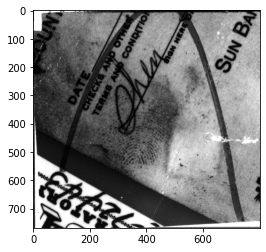

In [9]:
# Lendo a imagem de entrada e obtendo o seu tamanho como numpy array
%matplotlib inline

_, img_name = get_files_in_folder(deploy_set[0], '.bmp')
img_size = imageio.imread(deploy_set[0]+img_name[0]+'.bmp').shape
img_size = np.array(img_size, dtype=np.int32)/8*8

# Obtendo a main net
main_net_model = get_main_net((int(img_size[0]),int(img_size[1]),1), pretrain)
image = imageio.imread(deploy_set[0]+img_name[0]+'.bmp') / 255.0
image = image[:int(img_size[0]),:int(img_size[1])]      
plt.imshow(image, cmap = 'gray')
plt.show()
image = np.reshape(image,[1, image.shape[0], image.shape[1], 1])


2022-05-26 11:40:58.971325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-26 11:40:58.994120: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Text(0.5, 1.0, 'mnt_s_out')

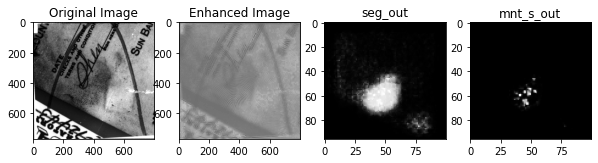

In [10]:
enhance_img, ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out = main_net_model.predict(image)
fig, ax = plt.subplots(figsize = (10,8),nrows = 1, ncols = 4)
ax[0].imshow(image.reshape(768,800,1), cmap = 'gray')
ax[0].set_title('Original Image')

ax[1].imshow(enhance_img.reshape(768,800,1), cmap = 'gray')
ax[1].set_title('Enhanced Image')

ax[2].imshow(seg_out.reshape(96,100,1), cmap = 'gray')
ax[2].set_title('seg_out')

ax[3].imshow(mnt_s_out.reshape(96,100,1), cmap = 'gray')
ax[3].set_title('mnt_s_out')


In [11]:
round_seg = np.round(np.squeeze(seg_out))

# Aplicando transformação morfológica de abertura na segmentação - redução de ruído
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
seg_out = cv2.morphologyEx(round_seg, cv2.MORPH_OPEN, kernel)

# extract 
mnt = label2mnt(np.squeeze(mnt_s_out)*np.round(np.squeeze(seg_out)), mnt_w_out, mnt_h_out, mnt_o_out, thresh=0.5)
# Non-maximum suppression(NMS) - Eliminate redundant minutiae points
mnt_nms = nms(mnt)

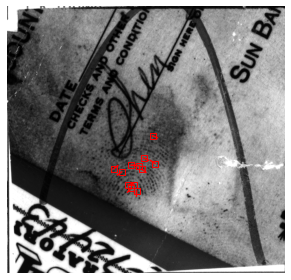

In [12]:
def draw_minutiae(image, minutiae, r=15):
    image = np.squeeze(image)
    fig = plt.figure()
    plt.imshow(image,cmap='gray')
    plt.plot(minutiae[:, 0], minutiae[:, 1], 'rs', fillstyle='none', linewidth=1)
    for x, y, o in minutiae:
        plt.plot([x, x+r*np.cos(o)], [y, y+r*np.sin(o)], 'r-')
    plt.axis([0,image.shape[1],image.shape[0],0])
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return
draw_minutiae(image, mnt_nms[:,:3])

## Pytorch

In [14]:
# Fingernet Finalizada!

def pytorch_img_normalization(im_input, m0 = 0.0, var0 = 1.0): # autoria Enrico
    
    im_input = torch.clone(im_input)
    m = torch.mean(im_input)
    var = torch.var(im_input)

    im_output =  torch.where(im_input > m, 
                (m0 + (torch.sqrt((var0*(im_input-m)*(im_input-m))/var))), 
                (m0-(torch.sqrt((var0*(im_input-m)*(im_input-m))/var))))
                
    return im_output

#atan2 function
def torch_atan2(enh_img_imag, enh_img_real):
    y,x = enh_img_imag, enh_img_real + 1e-7
    atan = torch.atan(y/x)
    angle = torch.where(x > torch.tensor([0]).double(), atan, torch.tensor([0]).double())
    cond1 = x < torch.tensor([0]).double()
    cond2 = y >= torch.tensor([0]).double()
    cond3 = y < torch.tensor([0]).double()
    angle = torch.where(cond1&cond2, atan + np.pi, angle)
    angle = torch.where(cond1&cond3, atan - np.pi, angle)
    return angle

def select_max(x):
    x = x / (K.max(x, axis=-1, keepdims=True)+K.epsilon())
    x = tf.where(tf.math.greater(x, 0.999), x, tf.compat.v1.zeros_like(x)) # select the biggest one
    x = x / (K.sum(x, axis=-1, keepdims=True)+K.epsilon()) # prevent two or more ori is selected
    return x  

# find highest peak using gaussian
def ori_highest_peak(y_pred, length=180):
    glabel = gausslabel(length=length,stride=2).astype(np.float32)
    ori_gau = K.conv2d(y_pred,glabel,padding='same')
    return ori_gau

def torch_ori_highest_peak(y_pred, length=180):
    glabel = torch.tensor(gausslabel(length=length,stride=2).astype(np.float32)).permute(3,2,0,1).double()
    ori_gau = nn.functional.conv2d(y_pred,glabel,padding='same')
    return ori_gau

def torch_select_max(x):
    x = x / (x.max(axis = 1, keepdims = True).values + 1e-7)
    x = torch.where(x > torch.tensor([0.999]).double(), x, torch.tensor([0]).double())
    x = x / (x.sum(axis = 1, keepdims = True) + 1e-7)
    return x

# Batch normalization

class MyBatchNorm(nn.Module):
    def __init__(self, n_channels, epsilon = 0.001):
        super().__init__()
        self.n_channels  = n_channels
        self.weight       = torch.nn.Parameter(torch.ones(self.n_channels))
        self.bias        = torch.nn.Parameter(torch.zeros(self.n_channels))
        self.running_mean = torch.nn.Parameter(torch.zeros(self.n_channels))
        self.running_var  = torch.nn.Parameter(torch.ones(self.n_channels))
        
        self.epsilon     = epsilon
        
    def forward(self,batch):
        _,_,height,width = batch.shape
        weight = self.weight.unsqueeze(1).unsqueeze(1).repeat(1,height,width)
        bias = self.bias.unsqueeze(1).unsqueeze(1).repeat(1,height,width)
        running_mean = self.running_mean.unsqueeze(1).unsqueeze(1).repeat(1,height,width)
        running_var = self.running_var.unsqueeze(1).unsqueeze(1).repeat(1,height,width)
        
        
        batch = weight * (batch - running_mean)/torch.sqrt(running_var + self.epsilon) + bias
        return batch


# definimos uma classe para o bloco convolucional para preservar a estrutura de nomes e camadas
# que temos no tensorflow.
class ConvBnPrelu(nn.Module):
    def __init__(self, ni, no, kernel_size, strides = (1,1), dilation_rate = (1,1)):
        super(ConvBnPrelu, self).__init__()
        self.conv2d = nn.Conv2d(ni, no, kernel_size = kernel_size, padding = 'same', stride = strides, dilation = dilation_rate)
        # self.bn = nn.BatchNorm2d(no,eps = 1e-3, momentum = 0.99, track_running_stats = True, affine = True)
        self.bn = MyBatchNorm(no)
        self.prelu = nn.PReLU(init = 0, num_parameters = no)
        
    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class MainNet(nn.Module): # autoria André
    def __init__(self, m0 = 0.0, var0 = 1.0):
        super(MainNet, self).__init__()
        self.m0 = m0
        self.var0 = var0
        
        # Feature extraction VGG
        self.conv1_1 = ConvBnPrelu(1, 64, (3,3))
        self.conv1_2 = ConvBnPrelu(64, 64, (3,3))
        self.conv2_1 = ConvBnPrelu(64, 128, (3,3))
        self.conv2_2 = ConvBnPrelu(128, 128, (3,3))
        self.conv3_1 = ConvBnPrelu(128, 256, (3,3))
        self.conv3_2 = ConvBnPrelu(256, 256, (3,3))
        self.conv3_3 = ConvBnPrelu(256, 256, (3,3))
        
        # multi-scale ASPP
        
        self.conv4_1 = ConvBnPrelu(256, 256, (3,3), dilation_rate = (1,1)) # scale_1
        self.convori_1_1 = ConvBnPrelu(256, 128, (1,1))
        self.ori_1_2 = nn.Conv2d(128, 90, (1,1), padding = 'same')
        self.convseg_1_1 = ConvBnPrelu(256, 128, (1,1))
        self.seg_1_2 = nn.Conv2d(128, 1, (1,1), padding = 'same')
        
        self.conv4_2 = ConvBnPrelu(256, 256, (3,3), dilation_rate = (4,4)) #scale_2
        self.convori_2_1 = ConvBnPrelu(256, 128, (1,1))
        self.ori_2_2 = nn.Conv2d(128, 90, (1,1), padding = 'same')
        self.convseg_2_1 = ConvBnPrelu(256, 128, (1,1))
        self.seg_2_2 = nn.Conv2d(128, 1, (1,1), padding = 'same')
        
        self.conv4_3 = ConvBnPrelu(256, 256, (3,3), dilation_rate = (8,8)) #scale_3
        self.convori_3_1 = ConvBnPrelu(256, 128, (1,1))
        self.ori_3_2 = nn.Conv2d(128, 90, (1,1), padding = 'same')
        self.convseg_3_1 = ConvBnPrelu(256, 128, (1,1))
        self.seg_3_2 = nn.Conv2d(128, 1, (1,1), padding = 'same')
        
        # ----------------------------------------------------------------------------
        # enhance part
        # filters_cos, filters_sin = gabor_bank(stride=2, Lambda=8) # unnecessary when simply deploying with pre-trained weights
        self.enh_img_real_1 = nn.Conv2d(1, 90, (25,25), padding = 'same')
        self.enh_img_imag_1 = nn.Conv2d(1, 90, (25,25), padding = 'same')
        
#         self.enh_img_real_1.weight.data = torch.from_numpy(filters_cos).permute(3,2,0,1).double()
#         self.enh_img_imag_1.weight.data = torch.from_numpy(filters_sin).permute(3,2,0,1).double()
        
#         self.enh_img_real_1.bias.data = torch.zeros(self.enh_img_real_1.bias.data.shape).double()
#         self.enh_img_imag_1.bias.data = torch.zeros(self.enh_img_imag_1.bias.data.shape).double()
        
        # ----------------------------------------------------------------------------
        # mnt part
        self.convmnt_1_1 = ConvBnPrelu(2, 64, (9,9))
        self.convmnt_2_1 = ConvBnPrelu(64, 128, (5,5))
        self.convmnt_3_1 = ConvBnPrelu(128, 256, (3,3))
        
        self.convmnt_o_1_1 = ConvBnPrelu(346, 256, (1,1)) # ni = 256 + 90 = n_channels(mnt_conv) + n_channels(ori_out_1)
        self.mnt_o_1_2 = nn.Conv2d(256, 180, (1,1), padding = 'same')
        
        self.convmnt_w_1_1 = ConvBnPrelu(256, 256, (1,1))
        self.mnt_w_1_2 = nn.Conv2d(256, 8, (1,1), padding = 'same')
        
        self.convmnt_h_1_1 = ConvBnPrelu(256, 256, (1,1))
        self.mnt_h_1_2 = nn.Conv2d(256, 8, (1,1), padding = 'same')
        
        self.convmnt_s_1_1 = ConvBnPrelu(256, 256, (1,1))
        self.mnt_s_1_2 = nn.Conv2d(256, 1, (1,1), padding = 'same')
        
        
        
    def forward(self, x):
        bn_image = pytorch_img_normalization(x, self.m0, self.var0)
        # Feature extraction VGG
        conv = self.conv1_1(bn_image)
        conv = self.conv1_2(conv)
        conv = nn.MaxPool2d(kernel_size=2, stride=2)(conv)
        
        conv = self.conv2_1(conv)
        conv = self.conv2_2(conv)
        conv = nn.MaxPool2d(kernel_size=2, stride=2)(conv)
        
        conv = self.conv3_1(conv)
        conv = self.conv3_2(conv)
        conv = self.conv3_3(conv)
        conv = nn.MaxPool2d(kernel_size=2, stride=2)(conv)
        
        # multi-scale ASPP
        
        scale1 = self.conv4_1(conv)
        ori_1 = self.convori_1_1(scale1)
        ori_1 = self.ori_1_2(ori_1)
        seg_1 = self.convseg_1_1(scale1)
        seg_1 = self.seg_1_2(seg_1)
        
        scale2 = self.conv4_2(conv)
        ori_2 = self.convori_2_1(scale2)
        ori_2 = self.ori_2_2(ori_2)
        seg_2 = self.convseg_2_1(scale2)
        seg_2 = self.seg_2_2(seg_2)
        
        scale3 = self.conv4_3(conv)
        ori_3 = self.convori_3_1(scale3)
        ori_3 = self.ori_3_2(ori_3)
        seg_3 = self.convseg_3_1(scale3)
        seg_3 = self.seg_3_2(seg_3)
        
        # sum fusion for ori
    
        ori_out = ori_1 + ori_2 + ori_3
        ori_out1 = nn.Sigmoid()(ori_out)
        ori_out2 = nn.Sigmoid()(ori_out)
        
        # sum fusion for segmentation
         
        seg_out = seg_1 + seg_2 + seg_3
        seg_out = nn.Sigmoid()(seg_out)
        
        # ----------------------------------------------------------------------------
        # enhance part
        
        filter_img_real = self.enh_img_real_1(x)
        filter_img_imag = self.enh_img_imag_1(x)
        
        ori_peak = torch_ori_highest_peak(ori_out1)
        
        ori_peak = torch_select_max(ori_peak)
        upsample_ori = nn.functional.upsample(ori_peak, scale_factor = 8)
        seg_round = nn.Softsign()(seg_out)
        upsample_seg = nn.functional.upsample(seg_round, scale_factor = 8)
        mul_mask_real = filter_img_real * upsample_ori
        enh_img_real = mul_mask_real.sum(axis = 1, keepdims = True)
        mul_mask_imag = filter_img_imag * upsample_ori
        enh_img_imag = mul_mask_imag.sum(axis = 1, keepdims = True)
        enh_img = torch_atan2(enh_img_imag, enh_img_real)
        
        enh_seg_img = torch.cat((enh_img, upsample_seg), 1)
        
        # ----------------------------------------------------------------------------
        # mnt part
        mnt_conv = self.convmnt_1_1(enh_seg_img)
        mnt_conv = nn.MaxPool2d(kernel_size=2, stride=2)(mnt_conv)
        
        mnt_conv = self.convmnt_2_1(mnt_conv)
        mnt_conv = nn.MaxPool2d(kernel_size=2, stride=2)(mnt_conv)
        
        mnt_conv = self.convmnt_3_1(mnt_conv)
        mnt_conv = nn.MaxPool2d(kernel_size=2, stride=2)(mnt_conv)
        
        mnt_o_1 = torch.cat((mnt_conv, ori_out1), 1)
        
        mnt_o_2 = self.convmnt_o_1_1(mnt_o_1)
        mnt_o_3 = self.mnt_o_1_2(mnt_o_2)
        mnt_o_out = nn.Sigmoid()(mnt_o_3)
        
        mnt_w_1 = self.convmnt_w_1_1(mnt_conv)
        mnt_w_2 = self.mnt_w_1_2(mnt_w_1)
        mnt_w_out = nn.Sigmoid()(mnt_w_2)
        
        mnt_h_1 = self.convmnt_h_1_1(mnt_conv)
        mnt_h_2 = self.mnt_h_1_2(mnt_h_1)
        mnt_h_out = nn.Sigmoid()(mnt_h_2)
        
        mnt_s_1 = self.convmnt_s_1_1(mnt_conv)
        mnt_s_2 = self.mnt_s_1_2(mnt_s_1)
        mnt_s_out = nn.Sigmoid()(mnt_s_2)
        
        return ori_out1, ori_out2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out
        # return (enh_img_real, ori_out1, ori_out2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out)
    

torch_main_net = MainNet().double()
torch_main_net.load_state_dict(torch.load('fingernet.pth'))


<All keys matched successfully>

In [15]:
# traditional orientation estimation
def get_orientation(image, stride=8, window=17):
    with tf.compat.v1.keras.backend.name_scope('orientation'):
        # assert image.get_shape().as_list()[3] == 1, 'Images must be grayscale'
        strides = [1, stride, stride, 1]
        E = np.ones([window, window, 1, 1])
        sobelx = np.reshape(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float), [3, 3, 1, 1])
        sobely = np.reshape(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float), [3, 3, 1, 1])
        gaussian = np.reshape(gaussian2d((5, 5), 1), [5, 5, 1, 1])
        with tf.compat.v1.keras.backend.name_scope('sobel_gradient'):
            Ix = tf.compat.v1.nn.conv2d(image, sobelx, strides=[1,1,1,1], padding='SAME', name='sobel_x')
            Iy = tf.compat.v1.nn.conv2d(image, sobely, strides=[1,1,1,1], padding='SAME', name='sobel_y')
        with tf.compat.v1.keras.backend.name_scope('eltwise_1'):
            Ix2 = tf.math.multiply(Ix, Ix, name='IxIx')
            Iy2 = tf.math.multiply(Iy, Iy, name='IyIy')
            Ixy = tf.math.multiply(Ix, Iy, name='IxIy')
        with tf.compat.v1.keras.backend.name_scope('range_sum'):
            Gxx = tf.compat.v1.nn.conv2d(Ix2, E, strides=strides, padding='SAME', name='Gxx_sum')
            Gyy = tf.compat.v1.nn.conv2d(Iy2, E, strides=strides, padding='SAME', name='Gyy_sum')
            Gxy = tf.compat.v1.nn.conv2d(Ixy, E, strides=strides, padding='SAME', name='Gxy_sum')
        with tf.compat.v1.keras.backend.name_scope('eltwise_2'):
            Gxx_Gyy = tf.math.subtract(Gxx, Gyy, name='Gxx_Gyy')
            theta = atan2([2*Gxy, Gxx_Gyy]) + np.pi
        # two-dimensional low-pass filter: Gaussian filter here
        with tf.compat.v1.keras.backend.name_scope('gaussian_filter'):
            phi_x = tf.compat.v1.nn.conv2d(tf.math.cos(theta), gaussian, strides=[1,1,1,1], padding='SAME', name='gaussian_x')
            phi_y = tf.compat.v1.nn.conv2d(tf.math.sin(theta), gaussian, strides=[1,1,1,1], padding='SAME', name='gaussian_y')
            theta = atan2([phi_y, phi_x])/2
    return theta

def torch_get_orientation(image, stride = 8, window = 17):
    strides = (stride, stride)
    E = torch.ones([1,1,window,window]).double()
    sobelx = torch.from_numpy(np.reshape(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float), [1,1,3,3]))
    sobely = torch.from_numpy(np.reshape(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float), [1,1,3,3]))

    gaussian = torch.from_numpy(np.reshape(gaussian2d((5, 5), 1), [1,1,5,5]))
    Ix = nn.functional.conv2d(image, sobelx, stride = 1, padding = 'same')
    Iy = nn.functional.conv2d(image, sobely, stride = 1, padding = 'same')

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    
    # padding Ix2, Iy2 and Ixy
    P_top,P_bot = GetPadConfig(Ix2.shape[2], window, stride)
    P_left,P_right = GetPadConfig(Ix2.shape[3], window, stride)
    Ix2 = nn.functional.pad(Ix2,(P_left,P_right,P_top,P_bot))
    
    P_top,P_bot = GetPadConfig(Iy2.shape[2], window, stride)
    P_left,P_right = GetPadConfig(Iy2.shape[3], window, stride)
    Iy2 = nn.functional.pad(Iy2,(P_left,P_right,P_top,P_bot))
    
    P_top,P_bot = GetPadConfig(Ixy.shape[2], window, stride)
    P_left,P_right = GetPadConfig(Ixy.shape[3], window, stride)
    Ixy = nn.functional.pad(Ixy,(P_left,P_right,P_top,P_bot))

    
    Gxx = nn.functional.conv2d(Ix2, E, stride = (stride, stride))
    Gyy = nn.functional.conv2d(Iy2, E, stride = (stride, stride))
    Gxy = nn.functional.conv2d(Ixy, E, stride = (stride, stride))

    Gxx_yy = Gxx - Gyy
    theta = torch_atan2(2*Gxy, Gxx_yy) + torch.pi

    phi_x = nn.functional.conv2d(torch.cos(theta), gaussian, padding = 'same')
    phi_y = nn.functional.conv2d(torch.sin(theta), gaussian, padding = 'same')

    theta = torch_atan2(phi_y, phi_x)/2
    
    return theta.permute(0,2,3,1).numpy()

In [16]:
import math
def GetPadConfig(input_size, kernel, stride):
    output_size = int(math.ceil(float(input_size) / float(stride)))
    pad_total = int((output_size - 1) * stride + kernel - input_size)
    pad_left = int(pad_total / 2)
    pad_right = pad_total - pad_left
    return pad_left, pad_right

In [228]:
stride = 8
window = 17
E = torch.ones([1,1,window,window]).double()


P_top,P_bot = GetPadConfig(ori.shape[2], window, stride)
P_left,P_right = GetPadConfig(ori.shape[3], window, stride)
Iy2 = torch.nn.functional.pad(Iy2,(P_left,P_right,P_top,P_bot))
Gyy = torch.nn.functional.conv2d(Iy2,E,stride = strides)#Gyy_sum
# output_size = int(math.ceil(float(ori.shape[2]) / float(stride)))
# pad_total = int((output_size - 1 ) * stride + kernel - ori.shape[2])

96


(4, 5)

In [17]:
class DatasetImage(Dataset): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.transform = transform
        self.images, self.seg_labels, self.ori_labels, self.mnt_labels = dataset
    def __len__(self): return len(self.images)        
    def __getitem__(self, ix): # returns the item at position ix
        image    = read(self.images[ix])
        seg      = read(self.seg_labels[ix])
        ori      = read(self.ori_labels[ix])
        mnts = np.array(mnt_reader(self.mnt_labels[ix]), dtype = float)
        if self.transform:
            image = self.transform(image).double()
            seg   = self.transform(seg).double()
            ori   = self.transform(ori).double()
        
        minutiae_w, minutiae_h, minutiae_o = mnt_prep(mnts)
        minutiae_w = minutiae_w.unsqueeze(3)
        minutiae_h = minutiae_h.unsqueeze(3)
        minutiae_o = minutiae_o.unsqueeze(3)
        
        
        label_seg = seg_prep(seg).unsqueeze(0)
        minutiae_seg = (minutiae_o!=-1).float()
        # return ori
        orientation = get_orientation(ori.unsqueeze(3).numpy()).numpy()
#         print('Tensorflow: ',orientation.shape)
        # orientation = torch_get_orientation(ori.unsqueeze(0))
#         print('Pytorch: ',orientation_torch.shape)
#         print('Comparação: ')
#         print('max: ', np.max(abs(orientation - orientation_torch)))
#         print('min: ', np.min(abs(orientation - orientation_torch)))
#         print('mean: ', np.mean(abs(orientation - orientation_torch)))
        
        
        
        orientation = orientation/np.pi*180+90
        orientation[orientation>=180.0] = 0.0 # orientation [0, 180)
        
        minutiae_o = minutiae_o/np.pi*180+90 # [90, 450)
        minutiae_o[minutiae_o>360] = minutiae_o[minutiae_o>360]-360 # to current coordinate system [0, 360)
        
        minutiae_ori_o = np.copy(minutiae_o) # copy one
        minutiae_ori_o[minutiae_ori_o>=180] = minutiae_ori_o[minutiae_ori_o>=180]-180 # for strong ori label [0,180)  
        
        
        # ori 2 gaussian
        gaussian_pdf = signal.gaussian(361, 3)
        y = np.reshape(np.arange(1, 180, 2), [1,1,1,-1])
        delta = np.array(np.abs(orientation - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori = torch.from_numpy(gaussian_pdf[delta]).squeeze().permute(2,0,1)
        
        # ori_o 2 gaussian
        delta = np.array(np.abs(minutiae_ori_o - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori_o = torch.from_numpy(gaussian_pdf[delta]).squeeze().permute(2,0,1)
        
        
        # mnt_o 2 gaussian
        y = np.reshape(np.arange(1, 360, 2), [1,1,1,-1])
        delta = np.array(np.abs(minutiae_o - y), dtype=int)  
        delta = np.minimum(delta, 360-delta)+180
        label_mnt_o = torch.from_numpy(gaussian_pdf[delta]).squeeze().permute(2,0,1)
        
        # w 2 gaussian
        gaussian_pdf = signal.gaussian(17, 2)
        y = np.reshape(np.arange(0, 8), [1,1,1,-1])
        delta = (minutiae_w-y+8).numpy().astype(int)
        label_mnt_w = torch.from_numpy(gaussian_pdf[delta]).squeeze().permute(2,0,1)
        
        # h 2 gaussian
        delta = (minutiae_h-y+8).numpy().astype(int)
        label_mnt_h = torch.from_numpy(gaussian_pdf[delta]).squeeze().permute(2,0,1)
        
        # mnt cls label -1:neg, 0:no care, 1:pos
        label_mnt_s = np.copy(minutiae_seg)
        label_mnt_s[label_mnt_s==0] = -1 # neg to -1
        label_mnt_s = (label_mnt_s+ndimage.maximum_filter(label_mnt_s, size=(1,3,3,1)))/2 # around 3*3 pos -> 0
        label_mnt_s = torch.from_numpy(label_mnt_s).squeeze(0).permute(2,0,1)

        # apply segmentation
        
        have_alignment = (torch.sum(label_ori) != 0).double()
        minutiae_seg = minutiae_seg.squeeze(3)
        
        label_ori = label_ori * label_seg * have_alignment
        label_ori_o = label_ori_o * minutiae_seg
        label_mnt_o = label_mnt_o * minutiae_seg
        label_mnt_w = label_mnt_w * minutiae_seg
        label_mnt_h = label_mnt_h * minutiae_seg
        
        return image, label_ori, label_ori_o, label_seg, label_mnt_w, label_mnt_h, label_mnt_o, label_mnt_s

def GetBatches(dataset, batchsize, transform = None):
    datatensor = DatasetImage(dataset, transform) 
    dataloader = DataLoader(datatensor, batch_size=batchsize)
    return(dataloader)

prep = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((768,800)),
    transforms.ToTensor()
])

def mnt_prep(mnt):
    minutiae_w = (torch.zeros((1, int(768/8), int(800/8)))-1).double()
    minutiae_h = (torch.zeros((1, int(768/8), int(800/8)))-1).double()
    minutiae_o = (torch.zeros((1, int(768/8), int(800/8)))-1).double()
    
    
    minutiae_w[0, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int)] = torch.from_numpy(mnt[:, 0] % 8).double()
    minutiae_h[0, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int)] = torch.from_numpy(mnt[:, 1] % 8).double()
    minutiae_o[0, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int)] = torch.from_numpy(mnt[:, 2]).double()

    return minutiae_w, minutiae_h, minutiae_o

def seg_prep(seg):
    label_seg = seg[0, ::8, ::8]
    label_seg[label_seg>0] = 1
    label_seg[label_seg<=0] = 0
    return label_seg


In [18]:
dataset    = '../datasets/NISTSD27/' # deploy_set[0]
#dataset    = train_set[0] # deploy_set[0]

images     = Glob(dataset + '/images/' + '*')
seg_labels = Glob(dataset + '/seg_labels/' +  '*')
ori_labels = Glob(dataset + '/ori_labels/' + '*')
mnt_labels = Glob(dataset + '/mnt_labels/' + '*.mnt')
fileset    = (images, seg_labels, ori_labels, mnt_labels)
batch_size = 1
datatensor = DatasetImage(fileset, prep)
dataloader = GetBatches(fileset, batch_size, prep)

In [19]:
with torch.no_grad():
    for ix, batch in enumerate(dataloader):
        print(f'Applying model to image {ix + 1}/{int(len(fileset[0])/batch_size)} ...')
        t_image, t_label_ori, t_label_ori_o, t_label_seg, t_label_mnt_w, t_label_mnt_h, t_label_mnt_o, t_label_mnt_s = batch
        t_ori_out_1, t_ori_out_2, t_seg_out, t_mnt_o_out, t_mnt_w_out, t_mnt_h_out, t_mnt_s_out = torch_main_net(batch[0])
        

Applying model to image 1/1 ...


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [20]:
train_set = ['../datasets/NISTSD27/']
k_image, k_label_ori, k_label_ori_o, k_label_seg, k_label_mnt_w, k_label_mnt_h, k_label_mnt_o,k_label_mnt_s, k_batch_name = load_data(train_set, tra_ori_model, rand=False, aug=0.0, batch_size=1, sample_rate=None)
MODE = 'train'
main_net_model = get_main_net((int(img_size[0]),int(img_size[1]),1), pretrain)
ori_out_1, ori_out_2, seg_out, mnt_o_out, mnt_w_out, mnt_h_out, mnt_s_out = main_net_model.predict(image)

2022-05-26 11:43:09.616256: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ../models/released_version/Model.model: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [21]:
def ori2angle(ori):
    sin2angle_ori = K.sum(ori*sin2angle, -1, keepdims=True)
    cos2angle_ori = K.sum(ori*cos2angle, -1, keepdims=True)
    
    modulus_ori = np.sqrt(K.square(sin2angle_ori)+K.square(cos2angle_ori))
    return sin2angle_ori, cos2angle_ori, modulus_ori

In [27]:
def ori_loss(y_true, y_pred, lamb=1.):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # get ROI
    label_seg = K.sum(y_true, axis=-1, keepdims=True)
    label_seg = tf.cast(tf.math.greater(label_seg, 0), tf.float32) 
    # weighted cross entropy loss
    lamb_pos, lamb_neg = 1., 1. 
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    logloss = logloss*label_seg # apply ROI
    logloss = -K.sum(logloss) / (K.sum(label_seg) + K.epsilon())
    # coherence loss, nearby ori should be as near as possible
    mean_kernal = np.reshape(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)/8, [3, 3, 1, 1])    
    sin2angle_ori, cos2angle_ori, modulus_ori = ori2angle(y_pred)
    sin2angle = K.conv2d(sin2angle_ori, mean_kernal, padding='same')
    cos2angle = K.conv2d(cos2angle_ori, mean_kernal, padding='same')
    
    modulus = K.conv2d(K.constant(modulus_ori), mean_kernal, padding='same')
    coherence = K.constant(np.sqrt(K.square(sin2angle) + K.square(cos2angle))) / (modulus + K.epsilon())
    coherenceloss = np.sum(label_seg) / (np.sum(coherence*label_seg) + K.epsilon()) - 1
    
    loss = logloss + lamb*coherenceloss
    return loss

In [28]:
def mnt_s_loss(y_true, y_pred):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # get ROI
    label_seg = tf.cast(tf.not_equal(y_true, 0.0), tf.float64) 
    y_true = tf.where(tf.less(y_true,0.0), tf.zeros_like(y_true), y_true) # set -1 -> 0
    # weighted cross entropy loss       
    total_elements = K.sum(label_seg) + K.epsilon()  
    lamb_pos, lamb_neg = 10., .5
    y_pred = tf.cast(y_pred, tf.float64)
    # return y_true, y_pred
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    
    # apply ROI
    logloss = logloss*label_seg
    logloss = -K.sum(logloss) / total_elements
    return logloss    

In [29]:
def seg_loss(y_true, y_pred, lamb=1.):
    # clip
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    # weighted cross entropy loss
    total_elements = K.sum(tf.ones_like(y_true))
    label_pos = tf.cast(tf.math.greater(y_true, 0.0), tf.float64)   
    lamb_pos = 0.5 * total_elements / K.sum(label_pos)
    lamb_neg = 1 / (2 - 1/lamb_pos)
    y_pred = tf.cast(y_pred, tf.float64)
    logloss = lamb_pos*y_true*K.log(y_pred)+lamb_neg*(1-y_true)*K.log(1-y_pred)
    logloss = -K.mean(K.sum(logloss, axis=-1))
    # smooth loss
    smooth_kernal = np.reshape(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float64)/8, [3, 3, 1, 1])
    smoothloss = K.mean(K.abs(K.conv2d(y_pred, smooth_kernal)))
    loss = logloss + lamb*smoothloss
    return loss

In [30]:
# Observando o erro -> WeightedCrossEntropy
print('Valores de referencia - loss tensorflow')
print('Strong orientation label: ', .1* ori_o_loss(k_label_ori_o, ori_out_2).numpy())

print('Weak orientation label: ', .1* ori_loss(k_label_ori, ori_out_1).numpy())
print('Weak segmentation label: ', 10*seg_loss(k_label_seg, seg_out).numpy())

print('Ground truth mnt o label: ', .5* ori_o_loss(k_label_mnt_o, mnt_o_out).numpy())
print('Ground truth mnt w label: ', .5* ori_o_loss(k_label_mnt_w, mnt_w_out).numpy())
print('Ground truth mnt h label: ', .5* ori_o_loss(k_label_mnt_h, mnt_h_out).numpy())
print('Ground truth mnt s label: ', 200* mnt_s_loss(k_label_mnt_s, mnt_s_out).numpy())



Valores de referencia - loss tensorflow
Strong orientation label:  1.1895129203796386
Weak orientation label:  1.2089808464050293
Weak segmentation label:  2.2949426742241514
Ground truth mnt o label:  6.032050132751465
Ground truth mnt w label:  2.4298856258392334
Ground truth mnt h label:  2.519465684890747
Ground truth mnt s label:  2.4973498165718535


In [31]:
def compare_results_old(pytorch_result, tensorflow_result, name):
    ptorch = pytorch_result.permute([0,2,3,1]).detach().numpy()
    print('---------------------------------')
    print('Comparando a diferença após ', name)
    print('Diferença máxima:', np.amax(np.abs(ptorch - tensorflow_result)))
    print('Diferença mínima:', np.amin(np.abs(ptorch - tensorflow_result)))
    print('Diferença média:', np.mean(np.abs(ptorch - tensorflow_result)))

In [51]:
# Se as labels são equivalentes e as saídas do modelo também, então os erros devem ser também

# recriando o weighted cross entropy (ori_o_loss)

# KERAS

y_pred_keras = ori_out_2
y_true_keras = k_label_ori_o
# clip
y_pred_keras = tf.clip_by_value(y_pred_keras, K.epsilon(), 1 - K.epsilon())
# get ROI
label_seg_keras = K.sum(y_true_keras, axis=-1, keepdims=True)
label_seg_keras = tf.cast(tf.math.greater(label_seg_keras, 0), tf.float32) 
# weighted cross entropy loss
lamb_pos, lamb_neg= 1., 1. 
logloss_keras = lamb_pos*y_true_keras*K.log(y_pred_keras)+lamb_neg*(1-y_true_keras)*K.log(1-y_pred_keras)
logloss_keras = logloss_keras*label_seg_keras # apply ROI
logloss_keras = -K.sum(logloss_keras) / (K.sum(label_seg_keras) + K.epsilon())

# PYTORCH

y_pred_ptorch = t_ori_out_2
y_true_ptorch = t_label_ori_o
# clip
y_pred_ptorch = torch.where(y_pred_ptorch < 1e-7, 1e-7, torch.where(y_pred_ptorch > (1 - 1e-7), 1 - 1e-7, y_pred_ptorch))
# get ROI
label_seg_ptorch = torch.sum(y_true_ptorch, axis = 1, keepdims=True)
label_seg_ptorch = (label_seg_ptorch > 0).double()
# weighted cross entropy loss
lamb_pos, lab_neg = 1., 1.
logloss_ptorch = lamb_pos*y_true_ptorch*torch.log(y_pred_ptorch) + lamb_neg*(1 - y_true_ptorch)*torch.log(1 - y_pred_ptorch)
logloss_ptorch = logloss_ptorch * label_seg_ptorch
logloss_ptorch = -torch.sum(logloss_ptorch) / (torch.sum(label_seg_ptorch) + 1e-7)


In [81]:
# recriando a coherence_loss (ori_loss)

y_pred_keras = ori_out_1
y_true_keras = k_label_ori
# clip
y_pred_keras = tf.clip_by_value(y_pred_keras, K.epsilon(), 1 - K.epsilon())
# get ROI
label_seg_keras = K.sum(y_true_keras, axis=-1, keepdims=True)
label_seg_keras = tf.cast(tf.math.greater(label_seg_keras, 0), tf.float32) 
# coherence loss, nearby ori should be as near as possible
mean_kernal_keras = np.reshape(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)/8, [3, 3, 1, 1])    
sin2angle_ori_keras, cos2angle_ori_keras, modulus_ori_keras = ori2angle(y_pred_keras)
sin2angle_keras = K.conv2d(sin2angle_ori_keras, mean_kernal_keras, padding='same')
cos2angle_keras = K.conv2d(cos2angle_ori_keras, mean_kernal_keras, padding='same')

modulus_keras = K.conv2d(K.constant(modulus_ori_keras), mean_kernal_keras, padding='same')
coherence_keras = K.constant(np.sqrt(K.square(sin2angle_keras) + K.square(cos2angle_keras))) / (modulus_keras + K.epsilon())
coherenceloss_keras = np.sum(label_seg_keras) / (np.sum(coherence_keras*label_seg_keras) + K.epsilon()) - 1

def ori2angle_ptorch(ori):
    kernal2angle = torch.from_numpy(np.reshape(np.arange(1, 180, 2, dtype=float), [1,90,1,1])/90.*np.pi) #2angle = angle*2
    sin2angle, cos2angle = torch.sin(kernal2angle), torch.cos(kernal2angle)
    sin2angle_ori = torch.sum(ori*sin2angle, axis = 1, keepdims=True)
    cos2angle_ori = torch.sum(ori*cos2angle, axis = 1, keepdims=True)
    modulus_ori = torch.sqrt(torch.square(sin2angle_ori) + torch.square(cos2angle_ori))
    return sin2angle_ori, cos2angle_ori, modulus_ori
    
y_pred_ptorch = t_ori_out_1
y_true_ptorch = t_label_ori
# clip
y_pred_ptorch = torch.where(y_pred_ptorch < 1e-7, 1e-7, torch.where(y_pred_ptorch > (1 - 1e-7), 1 - 1e-7, y_pred_ptorch))
# get ROI
label_seg_ptorch = torch.sum(y_true_ptorch, axis = 1, keepdims=True)
label_seg_ptorch = (label_seg_ptorch > 0).double()
#coherence loss
mean_kernal_ptorch = torch.from_numpy(np.reshape(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)/8, [1,1,3,3])).double()
sin2angle_ori_ptorch, cos2angle_ori_ptorch, modulus_ori_ptorch = ori2angle_ptorch(y_pred_ptorch)
sin2angle_ptorch = nn.functional.conv2d(sin2angle_ori_ptorch, mean_kernal_ptorch, padding = 'same')
cos2angle_ptorch = nn.functional.conv2d(cos2angle_ori_ptorch, mean_kernal_ptorch, padding = 'same')
modulus_ptorch = nn.functional.conv2d(modulus_ori_ptorch, mean_kernal_ptorch, padding = 'same')
coherence_ptorch = torch.sqrt(torch.square(sin2angle_ptorch) + torch.square(cos2angle_ptorch))/ (modulus_ptorch + 1e-7)
coherenceloss_ptorch = torch.sum(label_seg_ptorch) / (torch.sum(coherence_ptorch*label_seg_ptorch) + 1e-7) - 1





In [107]:
# Recriando a smooth segmentation loss (seg_loss)
y_pred_keras = seg_out
y_true_keras = k_label_seg
# clip
y_pred_keras = tf.clip_by_value(y_pred_keras, K.epsilon(), 1 - K.epsilon())
# weighted cross entropy loss
total_elements_keras = K.sum(tf.ones_like(y_true_keras))

label_pos_keras = tf.cast(tf.math.greater(y_true_keras, 0.0), tf.float64)   

lamb_pos_keras = 0.5 * total_elements_keras / K.sum(label_pos_keras)
lamb_neg_keras = 1 / (2 - 1/lamb_pos_keras)
y_pred_keras = tf.cast(y_pred_keras, tf.float64)
logloss_keras = lamb_pos_keras*y_true_keras*K.log(y_pred_keras)+lamb_neg_keras*(1-y_true_keras)*K.log(1-y_pred_keras)
logloss_keras = -K.mean(K.sum(logloss_keras, axis=-1))
# smooth loss
smooth_kernal_keras = np.reshape(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float64)/8, [3, 3, 1, 1])
smoothloss_keras = K.mean(K.abs(K.conv2d(y_pred_keras, smooth_kernal_keras)))

lamb_keras = 1.
loss_keras = logloss_keras + lamb_keras*smoothloss_keras

# pytorch
y_pred_ptorch = t_seg_out
y_true_ptorch = t_label_seg

y_pred_ptorch = torch.where(y_pred_ptorch < 1e-7, 1e-7, torch.where(y_pred_ptorch > (1 - 1e-7), 1 - 1e-7, y_pred_ptorch))

total_elements_ptorch = torch.sum(torch.ones(y_true_ptorch.shape))
label_pos_ptorch = (y_true_ptorch > 0).double()

lamb_pos_ptorch = 0.5 * total_elements_ptorch / torch.sum(label_pos_ptorch)
lamb_neg_ptorch = 1 / (2 - 1/lamb_pos_ptorch)

logloss_ptorch = lamb_pos_ptorch*y_true_ptorch*torch.log(y_pred_ptorch) + lamb_neg_ptorch*(1-y_true_ptorch)*torch.log(1-y_pred_ptorch)
logloss_ptorch = -torch.mean(torch.sum(logloss_ptorch, axis = 1))

# smooth loss
smooth_kernal_ptorch = torch.from_numpy(np.reshape(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float64)/8, [1, 1, 3, 3])).double()
smoothloss_ptorch = torch.mean(torch.abs(nn.functional.conv2d(y_pred_ptorch, smooth_kernal_ptorch)))

lamb_ptorch = 1.
loss_ptorch = logloss_ptorch + lamb_ptorch*smoothloss_ptorch

In [ ]:
# Recriando a mnt s loss


In [109]:
print('Diferença da coherence loss: ', (coherenceloss_ptorch - coherenceloss_keras).numpy())
print('Diferença da segmentation loss: ', (loss_ptorch - loss_keras).numpy())

Diferença da coherence loss:  2.7112213141222696e-08
Diferença da segmentation loss:  -2.6276298137339893e-08


In [77]:
compare_results_old(sin2angle_ori_ptorch, sin2angle_ori_keras, 'sin2angle')
compare_results_old(cos2angle_ori_ptorch, cos2angle_ori_keras, 'cos2angle')
compare_results_old(modulus_ori_ptorch, modulus_ori_keras, 'modulus_ori_keras')


---------------------------------
Comparando a diferença após  sin2angle
Diferença máxima: 1.579523e-05
Diferença mínima: 0.0
Diferença média: 1.3107956e-06
---------------------------------
Comparando a diferença após  cos2angle
Diferença máxima: 2.6464462e-05
Diferença mínima: 0.0
Diferença média: 1.4015592e-06
---------------------------------
Comparando a diferença após  modulus_ori_keras
Diferença máxima: 2.152112006292839e-05
Diferença mínima: 5.6782578639058556e-11
Diferença média: 1.382786882749344e-06


In [54]:
compare_results_old(y_pred_ptorch, y_pred_keras, 'y pred')
compare_results_old(label_seg_ptorch, label_seg_keras, 'label seg')
print('------------------------------')
print('Diferença da logloss: ', (logloss_ptorch - logloss_keras).numpy())

---------------------------------
Comparando a diferença após  y pred
Diferença máxima: 1.4007092e-06
Diferença mínima: 0.0
Diferença média: 5.1096087e-08
---------------------------------
Comparando a diferença após  label seg
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
------------------------------
Diferença da logloss:  9.536743e-07


In [32]:
def ori2angle_ptorch(ori):
    kernal2angle = torch.from_numpy(np.reshape(np.arange(1, 180, 2, dtype=float), [1,90,1,1])/90.*np.pi) #2angle = angle*2
    sin2angle, cos2angle = torch.sin(kernal2angle), torch.cos(kernal2angle)
    
    sin2angle_ori = torch.sum(ori*sin2angle, axis = 1, keepdims=True)
    cos2angle_ori = torch.sum(ori*cos2angle, axis = 1, keepdims=True)
    modulus_ori = torch.sqrt(torch.square(sin2angle_ori) + torch.square(cos2angle_ori))
    
    return sin2angle_ori, cos2angle_ori, modulus_ori

class CoherenceLoss(torch.nn.Module):
    """
    Coherence loss function
    """

    def __init__(self):
        super(CoherenceLoss, self).__init__()
    def forward(self, y_true, y_pred):
        # clip
        y_pred = torch.where(y_pred < 1e-7, 1e-7, torch.where(y_pred > (1 - 1e-7), 1 - 1e-7, y_pred))
        # get ROI
        label_seg = torch.sum(y_true, axis = 1, keepdims=True)
        label_seg = (label_seg > 0).double()
        
        #coherence loss
        mean_kernal = torch.from_numpy(np.reshape(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)/8, [1,1,3,3])).double()
        sin2angle_ori, cos2angle_ori, modulus_ori = ori2angle_ptorch(y_pred)
        
        sin2angle = nn.functional.conv2d(sin2angle_ori, mean_kernal, padding = 'same')
        cos2angle = nn.functional.conv2d(cos2angle_ori, mean_kernal, padding = 'same')
        modulus = nn.functional.conv2d(modulus_ori, mean_kernal, padding = 'same')
        
        coherence = torch.sqrt(torch.square(sin2angle) + torch.square(cos2angle))/ (modulus + 1e-7)
        coherenceloss = torch.sum(label_seg) / (torch.sum(coherence*label_seg) + 1e-7) - 1
        
        return coherenceloss

In [33]:
class WeightedCrossEntropyLoss(torch.nn.Module):
    """
    Weighted cross entropy loss function
    """

    def __init__(self, lambda_pos = 1.0, lambda_neg = 1.0):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.lambda_pos = lambda_pos
        self.lambda_neg = lambda_neg
    def forward(self, y_true, y_pred):
        # clip
        y_pred = torch.where(y_pred < 1e-7, 1e-7, torch.where(y_pred > (1 - 1e-7), 1 - 1e-7, y_pred))
        # get ROI
        label_seg = torch.sum(y_true, axis = 1, keepdims=True)
        label_seg = (label_seg > 0).double()
        # weighted cross entropy loss
        logloss = self.lambda_pos*y_true*torch.log(y_pred) + self.lambda_neg*(1 - y_true)*torch.log(1 - y_pred)
        logloss = logloss * label_seg
        logloss = -torch.sum(logloss) / (torch.sum(label_seg) + 1e-7)
        
        return logloss

In [34]:
class SegmentationLoss(torch.nn.Module):
    """
    Segmentation loss function.
    Represents the weak segmentation loss, which is equal to a cross entropy loss + smooth loss
    """

    def __init__(self, lamb = 1.):
        super(SegmentationLoss, self).__init__()
        self.lamb = lamb
    def forward(self, y_true, y_pred):
        y_pred = torch.where(y_pred < 1e-7, 1e-7, torch.where(y_pred > (1 - 1e-7), 1 - 1e-7, y_pred))
        label_pos = (y_true > 0).double()
        
        # modified weighted cross entropy part
        total_elements = torch.sum(torch.ones(y_true.shape))
        
        # positive and negative label weights
        lamb_pos = 0.5 * total_elements / torch.sum(label_pos)
        lamb_neg = 1 / (2 - 1/lamb_pos)

        # cross-entropy loss
        logloss = lamb_pos*y_true*torch.log(y_pred) + lamb_neg*(1-y_true)*torch.log(1-y_pred)
        logloss = -torch.mean(torch.sum(logloss, axis = 1))

        # smooth loss
        smooth_kernal = torch.from_numpy(np.reshape(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float64)/8, [1, 1, 3, 3])).double()
        smoothloss = torch.mean(torch.abs(nn.functional.conv2d(y_pred, smooth_kernal)))

        loss = logloss + self.lamb*smoothloss

        return loss

In [35]:
class MinutiaeScoreLoss(torch.nn.Module):
    """
    Minutiae score loss function.
    Represents the ground truth minutiae label score
    """

    def __init__(self):
        super(MinutiaeScoreLoss, self).__init__()
    def forward(self, y_true, y_pred):
        y_pred = torch.where(y_pred < 1e-7, 1e-7, torch.where(y_pred > (1 - 1e-7), 1 - 1e-7, y_pred))
        label_seg = (y_true != 0).double()
        y_true = torch.where(y_true < 0, 0.0, y_true.double())

        # weighted cross entropy loss
        total_elements = torch.sum(label_seg) + 1e-7
        lamb_pos, lamb_neg = 10., .5
        
        logloss = lamb_pos*y_true*torch.log(y_pred) + lamb_neg*(1-y_true)*torch.log(1-y_pred)

        # apply ROI
        logloss = logloss*label_seg
        logloss = -torch.sum(logloss) / total_elements
        return logloss

In [36]:
# Observando o erro -> WeightedCrossEntropy
print('Valores de referencia - loss tensorflow')
print('Strong orientation label: ', .1* ori_o_loss(k_label_ori_o, ori_out_2).numpy())

print('Weak orientation label: ', .1* ori_loss(k_label_ori, ori_out_1).numpy())
print('Weak segmentation label: ', 10*seg_loss(k_label_seg, seg_out).numpy())

print('Ground truth mnt o label: ', .5* ori_o_loss(k_label_mnt_o, mnt_o_out).numpy())
print('Ground truth mnt w label: ', .5* ori_o_loss(k_label_mnt_w, mnt_w_out).numpy())
print('Ground truth mnt h label: ', .5* ori_o_loss(k_label_mnt_h, mnt_h_out).numpy())
print('Ground truth mnt s label: ', 200* mnt_s_loss(k_label_mnt_s, mnt_s_out).numpy())



Valores de referencia - loss tensorflow
Strong orientation label:  1.1895129203796386
Weak orientation label:  1.2089808464050293
Weak segmentation label:  2.2949426742241514
Ground truth mnt o label:  6.032050132751465
Ground truth mnt w label:  2.4298856258392334
Ground truth mnt h label:  2.519465684890747
Ground truth mnt s label:  2.4973498165718535


In [37]:
# Observando o erro -> WeightedCrossEntropy pytorch
cross_entropy_loss = WeightedCrossEntropyLoss()
coherence_loss = CoherenceLoss()
segmentation_loss = SegmentationLoss()
minutiae_score_loss = MinutiaeScoreLoss()

print('Valores de referencia - loss pytorch')
print('Strong orientation label: ', .1* cross_entropy_loss(t_label_ori_o, t_ori_out_2).numpy())

print('Weak orientation label: ', .1* (coherence_loss(t_label_ori, t_ori_out_1) + cross_entropy_loss(t_label_ori, t_ori_out_1)).numpy())
print('Weak segmentation label: ', 10*segmentation_loss(t_label_seg, t_seg_out).numpy())

print('Ground truth mnt o label: ', .5* cross_entropy_loss(t_label_mnt_o, t_mnt_o_out).numpy())
print('Ground truth mnt w label: ', .5* cross_entropy_loss(t_label_mnt_w, t_mnt_w_out).numpy())
print('Ground truth mnt h label: ', .5* cross_entropy_loss(t_label_mnt_h, t_mnt_h_out).numpy())
print('Ground truth mnt s label: ', 200* minutiae_score_loss(t_label_mnt_s, t_mnt_s_out).numpy())



Valores de referencia - loss pytorch
Strong orientation label:  1.1895130280930926
Weak orientation label:  1.208980730228175
Weak segmentation label:  2.29494241146117
Ground truth mnt o label:  6.032049403408101
Ground truth mnt w label:  2.4298854027376198
Ground truth mnt h label:  2.519466419038074
Ground truth mnt s label:  2.4973448918161494


In [38]:
def compare_results(ptorch, keras, name):
    ptorch = ptorch.unsqueeze(0).permute([0,2,3,1]).detach().cpu().numpy()
    print('---------------------------------')
    print('Comparando a diferença após ', name)
    print('Diferença máxima:', np.amax(np.abs(ptorch - keras)))
    print('Diferença mínima:', np.amin(np.abs(ptorch - keras)))
    print('Diferença média:', np.mean(np.abs(ptorch - keras)))

compare_results_old(t_image, k_image, 'image')
compare_results_old(t_label_ori, k_label_ori, 'label_ori')
compare_results_old(t_label_ori_o, k_label_ori_o, 'label_ori_o')
compare_results_old(t_label_seg, k_label_seg, 'label_seg')
compare_results_old(t_label_mnt_w, k_label_mnt_w, 'label_mnt_w')
compare_results_old(t_label_mnt_h, k_label_mnt_h, 'label_mnt_h')
compare_results_old(t_label_mnt_o, k_label_mnt_o, 'label_mnt_o')
compare_results_old(t_label_mnt_s, k_label_mnt_s, 'label_mnt_s')

---------------------------------
Comparando a diferença após  image
Diferença máxima: 2.9685450542160652e-08
Diferença mínima: 0.0
Diferença média: 1.0695871019841883e-08
---------------------------------
Comparando a diferença após  label_ori
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
---------------------------------
Comparando a diferença após  label_ori_o
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
---------------------------------
Comparando a diferença após  label_seg
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
---------------------------------
Comparando a diferença após  label_mnt_w
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
---------------------------------
Comparando a diferença após  label_mnt_h
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença média: 0.0
---------------------------------
Comparando a diferença após  label_mnt_o
Diferença máxima: 0.0
Diferença mínima: 0.0
Diferença méd

In [39]:
compare_results_old(t_ori_out_1, ori_out_1, 'ori out 1')
compare_results_old(t_ori_out_2, ori_out_2, 'ori out 2')
compare_results_old(t_seg_out, seg_out, 'seg out')
compare_results_old(t_mnt_o_out, mnt_o_out, 'mnt_o')
compare_results_old(t_mnt_w_out, mnt_w_out, 'mnt_w')
compare_results_old(t_mnt_h_out, mnt_h_out, 'mnt_h')
compare_results_old(t_mnt_s_out, mnt_s_out, 'mnt_s')

---------------------------------
Comparando a diferença após  ori out 1
Diferença máxima: 1.3872501412048877e-06
Diferença mínima: 1.820071870994866e-14
Diferença média: 5.112784822505265e-08
---------------------------------
Comparando a diferença após  ori out 2
Diferença máxima: 1.3872501412048877e-06
Diferença mínima: 1.820071870994866e-14
Diferença média: 5.112784822505265e-08
---------------------------------
Comparando a diferença após  seg out
Diferença máxima: 8.561261846673496e-07
Diferença mínima: 1.0408998749739107e-11
Diferença média: 4.073461547171508e-08
---------------------------------
Comparando a diferença após  mnt_o
Diferença máxima: 1.4143033333080535e-06
Diferença mínima: 2.8667488402133235e-21
Diferença média: 3.627138754461157e-08
---------------------------------
Comparando a diferença após  mnt_w
Diferença máxima: 1.5450462518828978e-06
Diferença mínima: 7.083222897108499e-14
Diferença média: 5.043628026549135e-08
---------------------------------
Comparando

In [26]:
sub_load_data()

(array(['A0100003009991600022036_2'], dtype='<U25'),
 array(['../datasets/CISL24218/'], dtype='<U22'),
 array([512, 512], dtype=int32))

In [ ]:
class FingerNetDataset(Dataset):
    def __init__(self, image_folder, imagenames_file, transform=None):
        self.image_folder    = image_folder
        self.imagenames_file = imagenames_file
        self.nitems          = 0
        self.transform       = transform

        f     = open(self.imagenames_file,"r")
        self.pairs = []
        for line in f:
            pair = line.strip().split(" ")
            self.pairs.append(pair)

        self.nitems = len(self.pairs)

    def __getitem__(self, ix):
        image1      = self.pairs[ix][0]
        image2      = self.pairs[ix][1]
        
        person1 = image1.split("_")[0] # 001_01.png -> 001
        person2 = image2.split("_")[0] # 002_01.png -> 002
        
        if (person1 == person2):
            truelabel = 0
        else:
            truelabel = 1
        
        image1 = read("{}/{}".format(self.image_folder,image1))
        image2 = read("{}/{}".format(self.image_folder,image2))
        image1 = np.expand_dims(image1,2)
        image2 = np.expand_dims(image2,2)
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, np.array([truelabel])
    def __len__(self):
        return self.nitems

prep = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.ToTensor()
])